In [29]:
import json
import pandas as pd
from tqdm import tqdm

# Load JSON file 
with open(r'C:\Users\Abdul Wajeed\Downloads\user-wallet-transactions.json', 'r') as f:
    data = json.load(f)


print(data[0])

{'_id': {'$oid': '681d38fed63812d4655f571a'}, 'userWallet': '0x00000000001accfa9cef68cf5371a23025b6d4b6', 'network': 'polygon', 'protocol': 'aave_v2', 'txHash': '0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190', 'logId': '0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190_Deposit', 'timestamp': 1629178166, 'blockNumber': 1629178166, 'action': 'deposit', 'actionData': {'type': 'Deposit', 'amount': '2000000000', 'assetSymbol': 'USDC', 'assetPriceUSD': '0.9938318274296357543568636362026045', 'poolId': '0x2791bca1f2de4661ed88a30c99a7a9449aa84174', 'userId': '0x00000000001accfa9cef68cf5371a23025b6d4b6'}, '__v': 0, 'createdAt': {'$date': '2025-05-08T23:06:39.465Z'}, 'updatedAt': {'$date': '2025-05-08T23:06:39.465Z'}}


In [ ]:
records = []

for tx in tqdm(data):
    wallet = tx.get('userWallet')
    timestamp = pd.to_datetime(tx.get('timestamp'), unit='s')
    action = tx.get('action')
    amount_raw = float(tx['actionData'].get('amount', 0))
    asset = tx['actionData'].get('assetSymbol', 'UNKNOWN')
    price_usd = float(tx['actionData'].get('assetPriceUSD', 1.0))  
    amount_usd = amount_raw * price_usd / (10**6)  # 
    
    records.append({
        'wallet': wallet,
        'timestamp': timestamp,
        'action': action.lower(),
        'asset': asset,
        'amount_usd': amount_usd
    })

df = pd.DataFrame(records)
df.head()

100%|██████████| 100000/100000 [00:08<00:00, 11983.52it/s]


,wallet,timestamp,action,asset,amount_usd
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,2021-08-17 05:29:26,deposit,USDC,1.987664e+03
1,0x000000000051d07a4fb3bd10121a343d85818da6,2021-05-20 15:36:53,deposit,WMATIC,2.856945e+14
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2021-07-24 09:28:33,deposit,WMATIC,9.223773e+08
3,0x000000000096026fb41fc39f9875d164bd82e2dc,2021-07-31 23:15:18,deposit,WMATIC,4.229933e+09
4,0x0000000000e189dd664b9ab08a33c4839953852c,2021-04-19 15:25:07,redeemunderlying,USDC,5.026161e-01


In [31]:
# Group by wallet
wallet_features = []

for wallet, group in tqdm(df.groupby('wallet')):
    group = group.sort_values('timestamp')
    deposits = group[group['action'] == 'deposit']['amount_usd'].sum()
    borrows = group[group['action'] == 'borrow']['amount_usd'].sum()
    repays = group[group['action'] == 'repay']['amount_usd'].sum()
    redemptions = group[group['action'] == 'redeemunderlying']['amount_usd'].sum()
    liquidations = group[group['action'] == 'liquidationcall'].shape[0]
    
    repay_ratio = repays / borrows if borrows > 0 else 0
    borrow_deposit_ratio = borrows / deposits if deposits > 0 else 0
    txn_count = len(group)
    asset_diversity = group['asset'].nunique()
    avg_txn_size = group['amount_usd'].mean()
    txn_span_days = (group['timestamp'].max() - group['timestamp'].min()).days + 1
    txn_freq = txn_count / txn_span_days if txn_span_days > 0 else 0

    wallet_features.append({
        'wallet': wallet,
        'total_deposit': deposits,
        'total_borrow': borrows,
        'total_repay': repays,
        'repay_ratio': repay_ratio,
        'borrow_deposit_ratio': borrow_deposit_ratio,
        'num_liquidations': liquidations,
        'txn_count': txn_count,
        'asset_diversity': asset_diversity,
        'avg_txn_size': avg_txn_size,
        'txn_span_days': txn_span_days,
        'txn_freq': txn_freq
    })

features_df = pd.DataFrame(wallet_features)


100%|██████████| 3497/3497 [00:06<00:00, 577.30it/s]


In [32]:
from sklearn.preprocessing import MinMaxScaler

# Scoring formula (adjust weights as needed)
features_df['score_raw'] = (
    features_df['total_deposit'] * 0.2 +
    features_df['repay_ratio'] * 200 +
    features_df['txn_freq'] * 50 +
    features_df['asset_diversity'] * 30 +
    features_df['avg_txn_size'] * 0.1
) - (
    features_df['num_liquidations'] * 200 +
    features_df['borrow_deposit_ratio'] * 100
)

# Normalize to 0-1000
scaler = MinMaxScaler(feature_range=(0, 1000))
features_df['credit_score'] = scaler.fit_transform(features_df[['score_raw']])

# Final output
final_scores = features_df[['wallet', 'credit_score']].sort_values(by='credit_score', ascending=False)
final_scores.head()


,wallet,credit_score
137,0x0034baeeb160a5f1032b6d124d3e87cc94d74e62,1000.000000
54,0x000f7f22bfc28d940d4b68e13213ab17cf107790,686.367191
3178,0x058b10cbe1872ad139b00326686ee8ccef274c58,683.091855
1299,0x022b3fa410364e1e28054b704b0da3b67aa6dc90,532.077970
1733,0x02eca8cc78b7d30c1ac5e16988ed2c8a9da658d6,495.268495


In [ ]:
final_scores.to_csv('wallet_credit_scores.csv', index=False)
print("Wallet credit scores saved to 'wallet_credit_scores.csv'")


Wallet credit scores saved to 'wallet_credit_scores.csv'
<class 'pandas.core.frame.DataFrame'>
Index: 3497 entries, 137 to 642
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wallet        3497 non-null   object 
 1   credit_score  3497 non-null   float64
dtypes: float64(1), object(1)
memory usage: 82.0+ KB


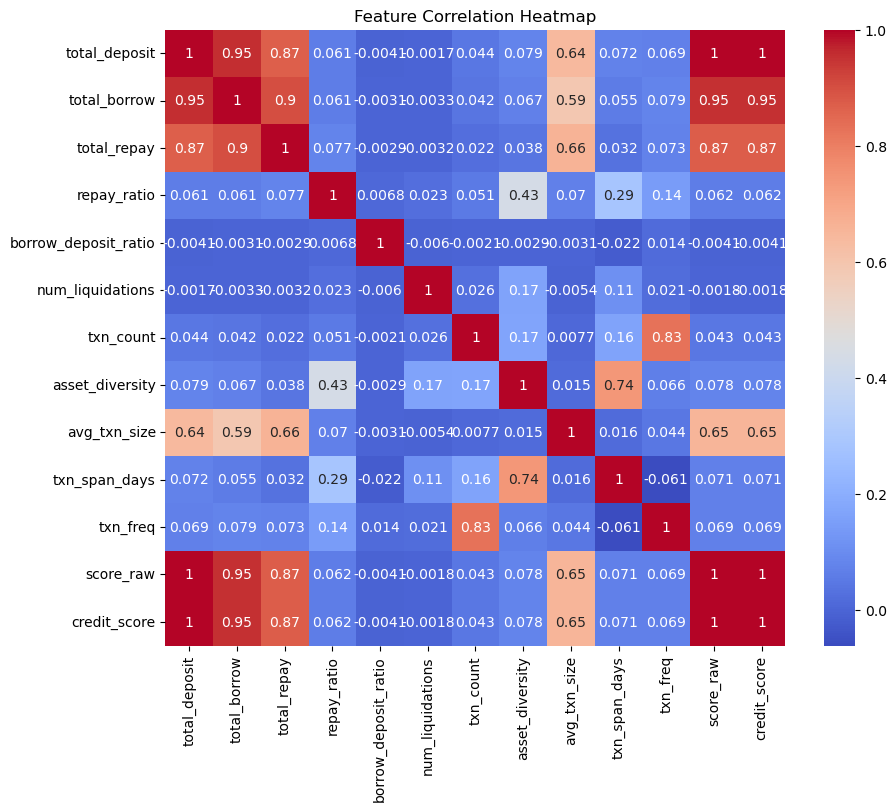

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot pairwise correlation
plt.figure(figsize=(10, 8))
sns.heatmap(features_df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


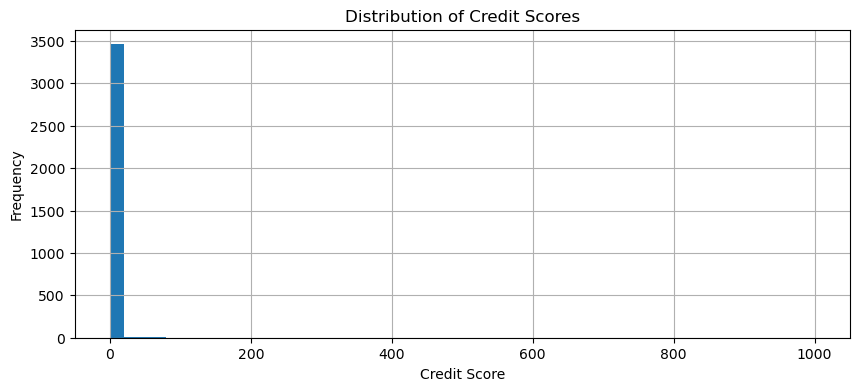

In [39]:
# Histogram of credit scores
features_df['credit_score'].hist(bins=50, figsize=(10, 4))
plt.title('Distribution of Credit Scores')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.show()


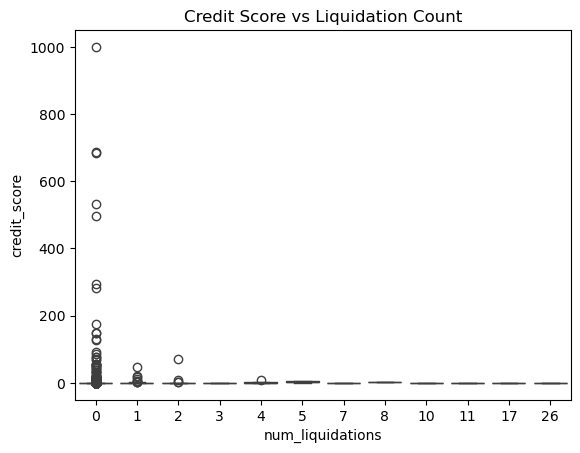

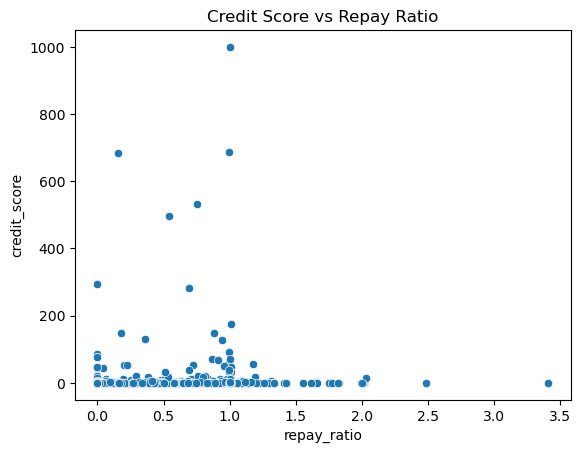

In [40]:
# Boxplots to understand impact of liquidations, repay ratio
sns.boxplot(data=features_df, x='num_liquidations', y='credit_score')
plt.title('Credit Score vs Liquidation Count')
plt.show()

sns.scatterplot(data=features_df, x='repay_ratio', y='credit_score')
plt.title('Credit Score vs Repay Ratio')
plt.show()


In [41]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select relevant features
X = features_df[[
    'total_deposit', 'total_borrow', 'repay_ratio',
    'borrow_deposit_ratio', 'num_liquidations',
    'txn_freq', 'asset_diversity', 'avg_txn_size'
]]

# Normalize for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
features_df['cluster'] = kmeans.fit_predict(X_scaled)


In [42]:
# Map clusters to score ranges (manually or by centroid analysis)
cluster_scores = {
    0: 800,  # e.g. good
    1: 400,  # average
    2: 200   # risky
}
features_df['ml_credit_score'] = features_df['cluster'].map(cluster_scores)

# View result
features_df[['wallet', 'cluster', 'ml_credit_score']].head()


,wallet,cluster,ml_credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,2,200
1,0x000000000051d07a4fb3bd10121a343d85818da6,2,200
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,200
3,0x0000000000e189dd664b9ab08a33c4839953852c,2,200
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,0,800


In [43]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.05, random_state=42)
features_df['anomaly'] = model.fit_predict(X_scaled)

# Map to scores
features_df['anomaly_score'] = model.decision_function(X_scaled)
features_df['ml_credit_score'] = MinMaxScaler((0, 1000)).fit_transform(
    features_df[['anomaly_score']]
)
